# Read SIC data

In [1]:
path='D:/VScode/Last_deglaciation/data/LGMR_SIC_May2023.nc'

# read the nc file from the path
import xarray as xr
import numpy as np

ds_seaice = xr.open_dataset(path)
ds_seaice = ds_seaice.where(ds_seaice.age>=11000, drop=True)

# Calculate the weight based on latitude
weight = np.cos(np.deg2rad(ds_seaice['lat']))
print('shape of the weight:', weight.shape)

weight = xr.where(weight < 0, 0, weight)

ds_seaice['weight'] = weight



ds_seaice.info

shape of the weight: (96,)


c:\Users\zps19\.conda\envs\pz-env\lib\site-packages\xarray\coding\variables.py:148: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
c:\Users\zps19\.conda\envs\pz-env\lib\site-packages\xarray\coding\variables.py:148: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


<bound method Dataset.info of <xarray.Dataset>
Dimensions:  (dims: 5, age: 65, lat: 96, lon: 144)
Coordinates:
  * lat      (lat) float32 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * age      (age) float32 1.11e+04 1.13e+04 1.15e+04 ... 2.37e+04 2.39e+04
  * dims     (dims) object 'mean              ' ... '97.5percentile    '
Data variables:
    sic      (dims, age, lat, lon) float32 0.0 0.0 0.0 ... 0.9979 0.9979 0.9979
    weight   (lat) float32 0.0 0.03306 0.06609 0.09905 ... 0.06609 0.03306 0.0>

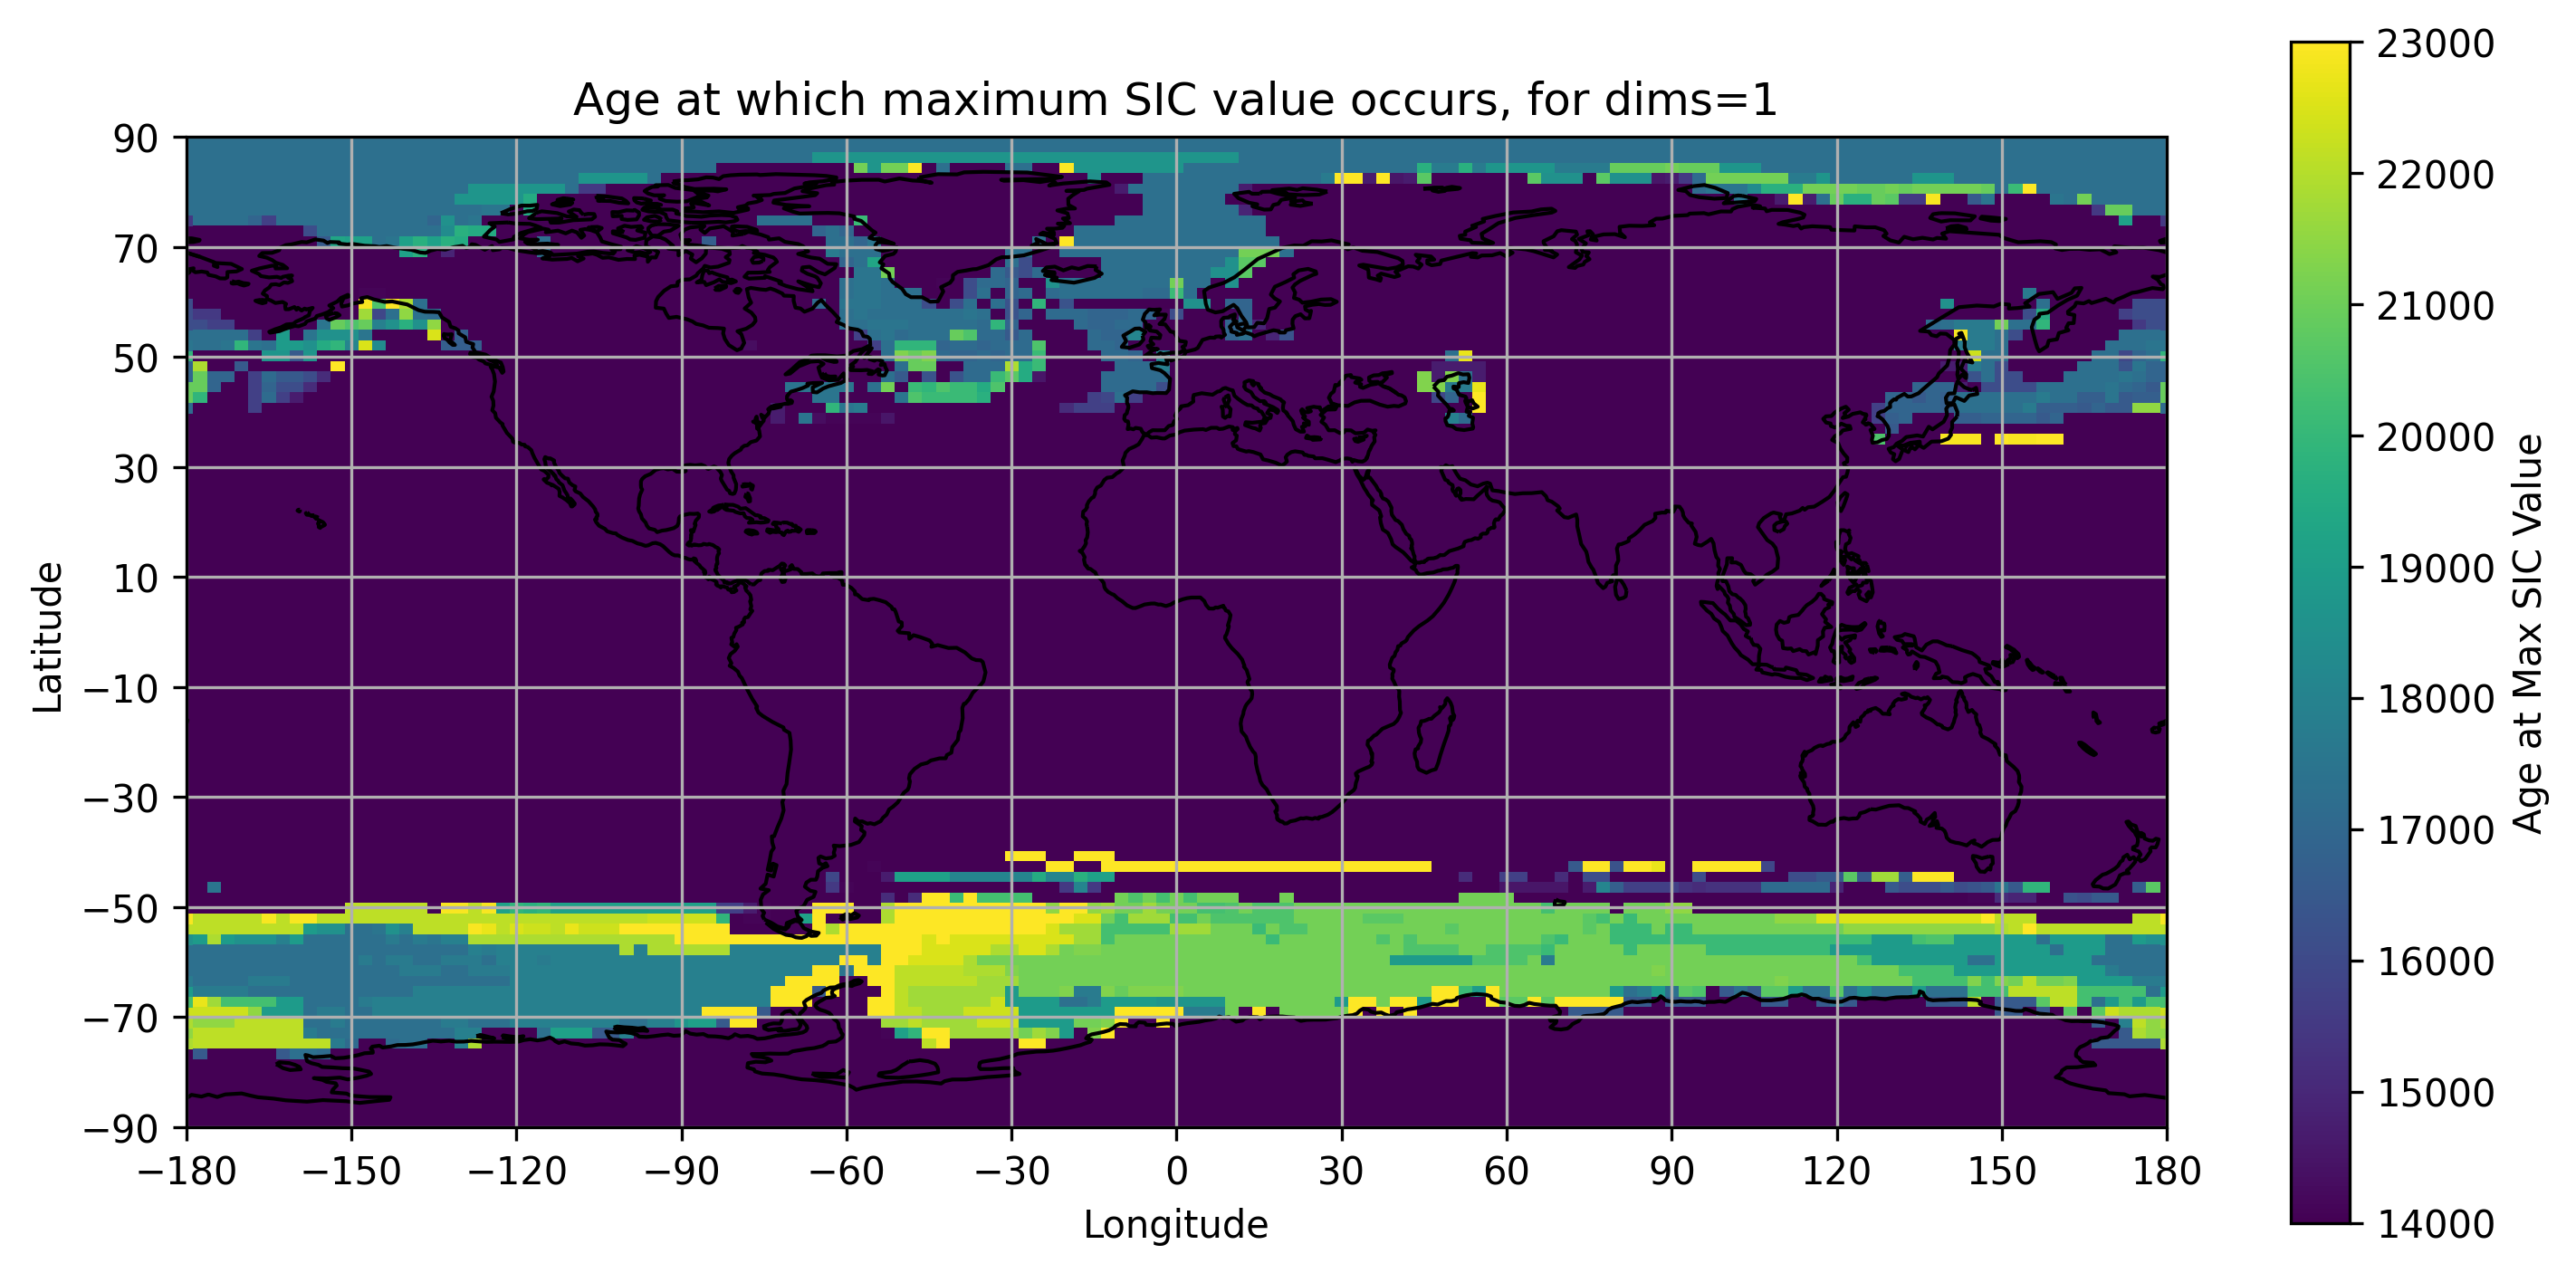

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create a single subplot with PlateCarree projection
fig, ax = plt.subplots(figsize=(10, 9), subplot_kw={'projection': ccrs.PlateCarree()}, dpi=300)

# Add coastline to the subplot
ax.add_feature(cfeature.COASTLINE)

# Choose the dimension you are interested in (0 or 1)
dim = 1

# Find the age where the maximum sic value occurs along the 'age' dimension for the chosen dim
age_max_idx = ds_seaice['sic'].isel(dims=dim).idxmax(dim='age')
transitions = age_max_idx.values
# Set transitions less than 10000 to nan
transitions[transitions < 10000] = np.nan

# Using pcolormesh for the heatmap
c = ax.pcolormesh(ds_seaice['lon'], ds_seaice['lat'], transitions, shading='auto', vmin=14000, vmax=23000)

# Adding colorbar and labels
plt.colorbar(c, ax=ax, shrink=0.5, label='Age at Max SIC Value')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'Age at which maximum SIC value occurs, for dims={dim}')

# Add lat-lon grid with 10-degree steps
ax.set_xticks(np.arange(-180, 181, 30), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90, 91, 20), crs=ccrs.PlateCarree())
ax.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


# Select the SIC data of given latitude band, divide them according to longitude

In [2]:
selected_data = ds_seaice['sic'].isel(dims=1).sel(lat=slice(-75, -60))
weights = ds_seaice['weight'].sel(lat=slice(-75, -60))

weights_expanded = weights.expand_dims(dim={'lon': selected_data.lon, 'age': selected_data.age}, axis=[1, 2])

longitude_step = 60
weighted_avg_sic = {}


for lon in range(0, 360, longitude_step):
    lon_slice = slice(lon, lon + longitude_step)
    data_group = selected_data.sel(lon=lon_slice)
    weights_group = weights_expanded.sel(lon=lon_slice)
    # remove the data from data_group where it is all zero
    data_group = data_group.where(data_group > 0, drop=True)
    # remove the weights from weights_group where data from data_group is all zero
    weights_group = weights_group.where(data_group > 0, drop=True)
    
    # Calculate weighted average
    weighted_avg = (data_group * weights_group).sum(dim=['lat', 'lon']) / weights_group.sum(dim=['lat', 'lon'])
    weighted_avg_sic[f'{lon}-{lon + longitude_step}'] = weighted_avg.values

# print(weighted_avg_sic)



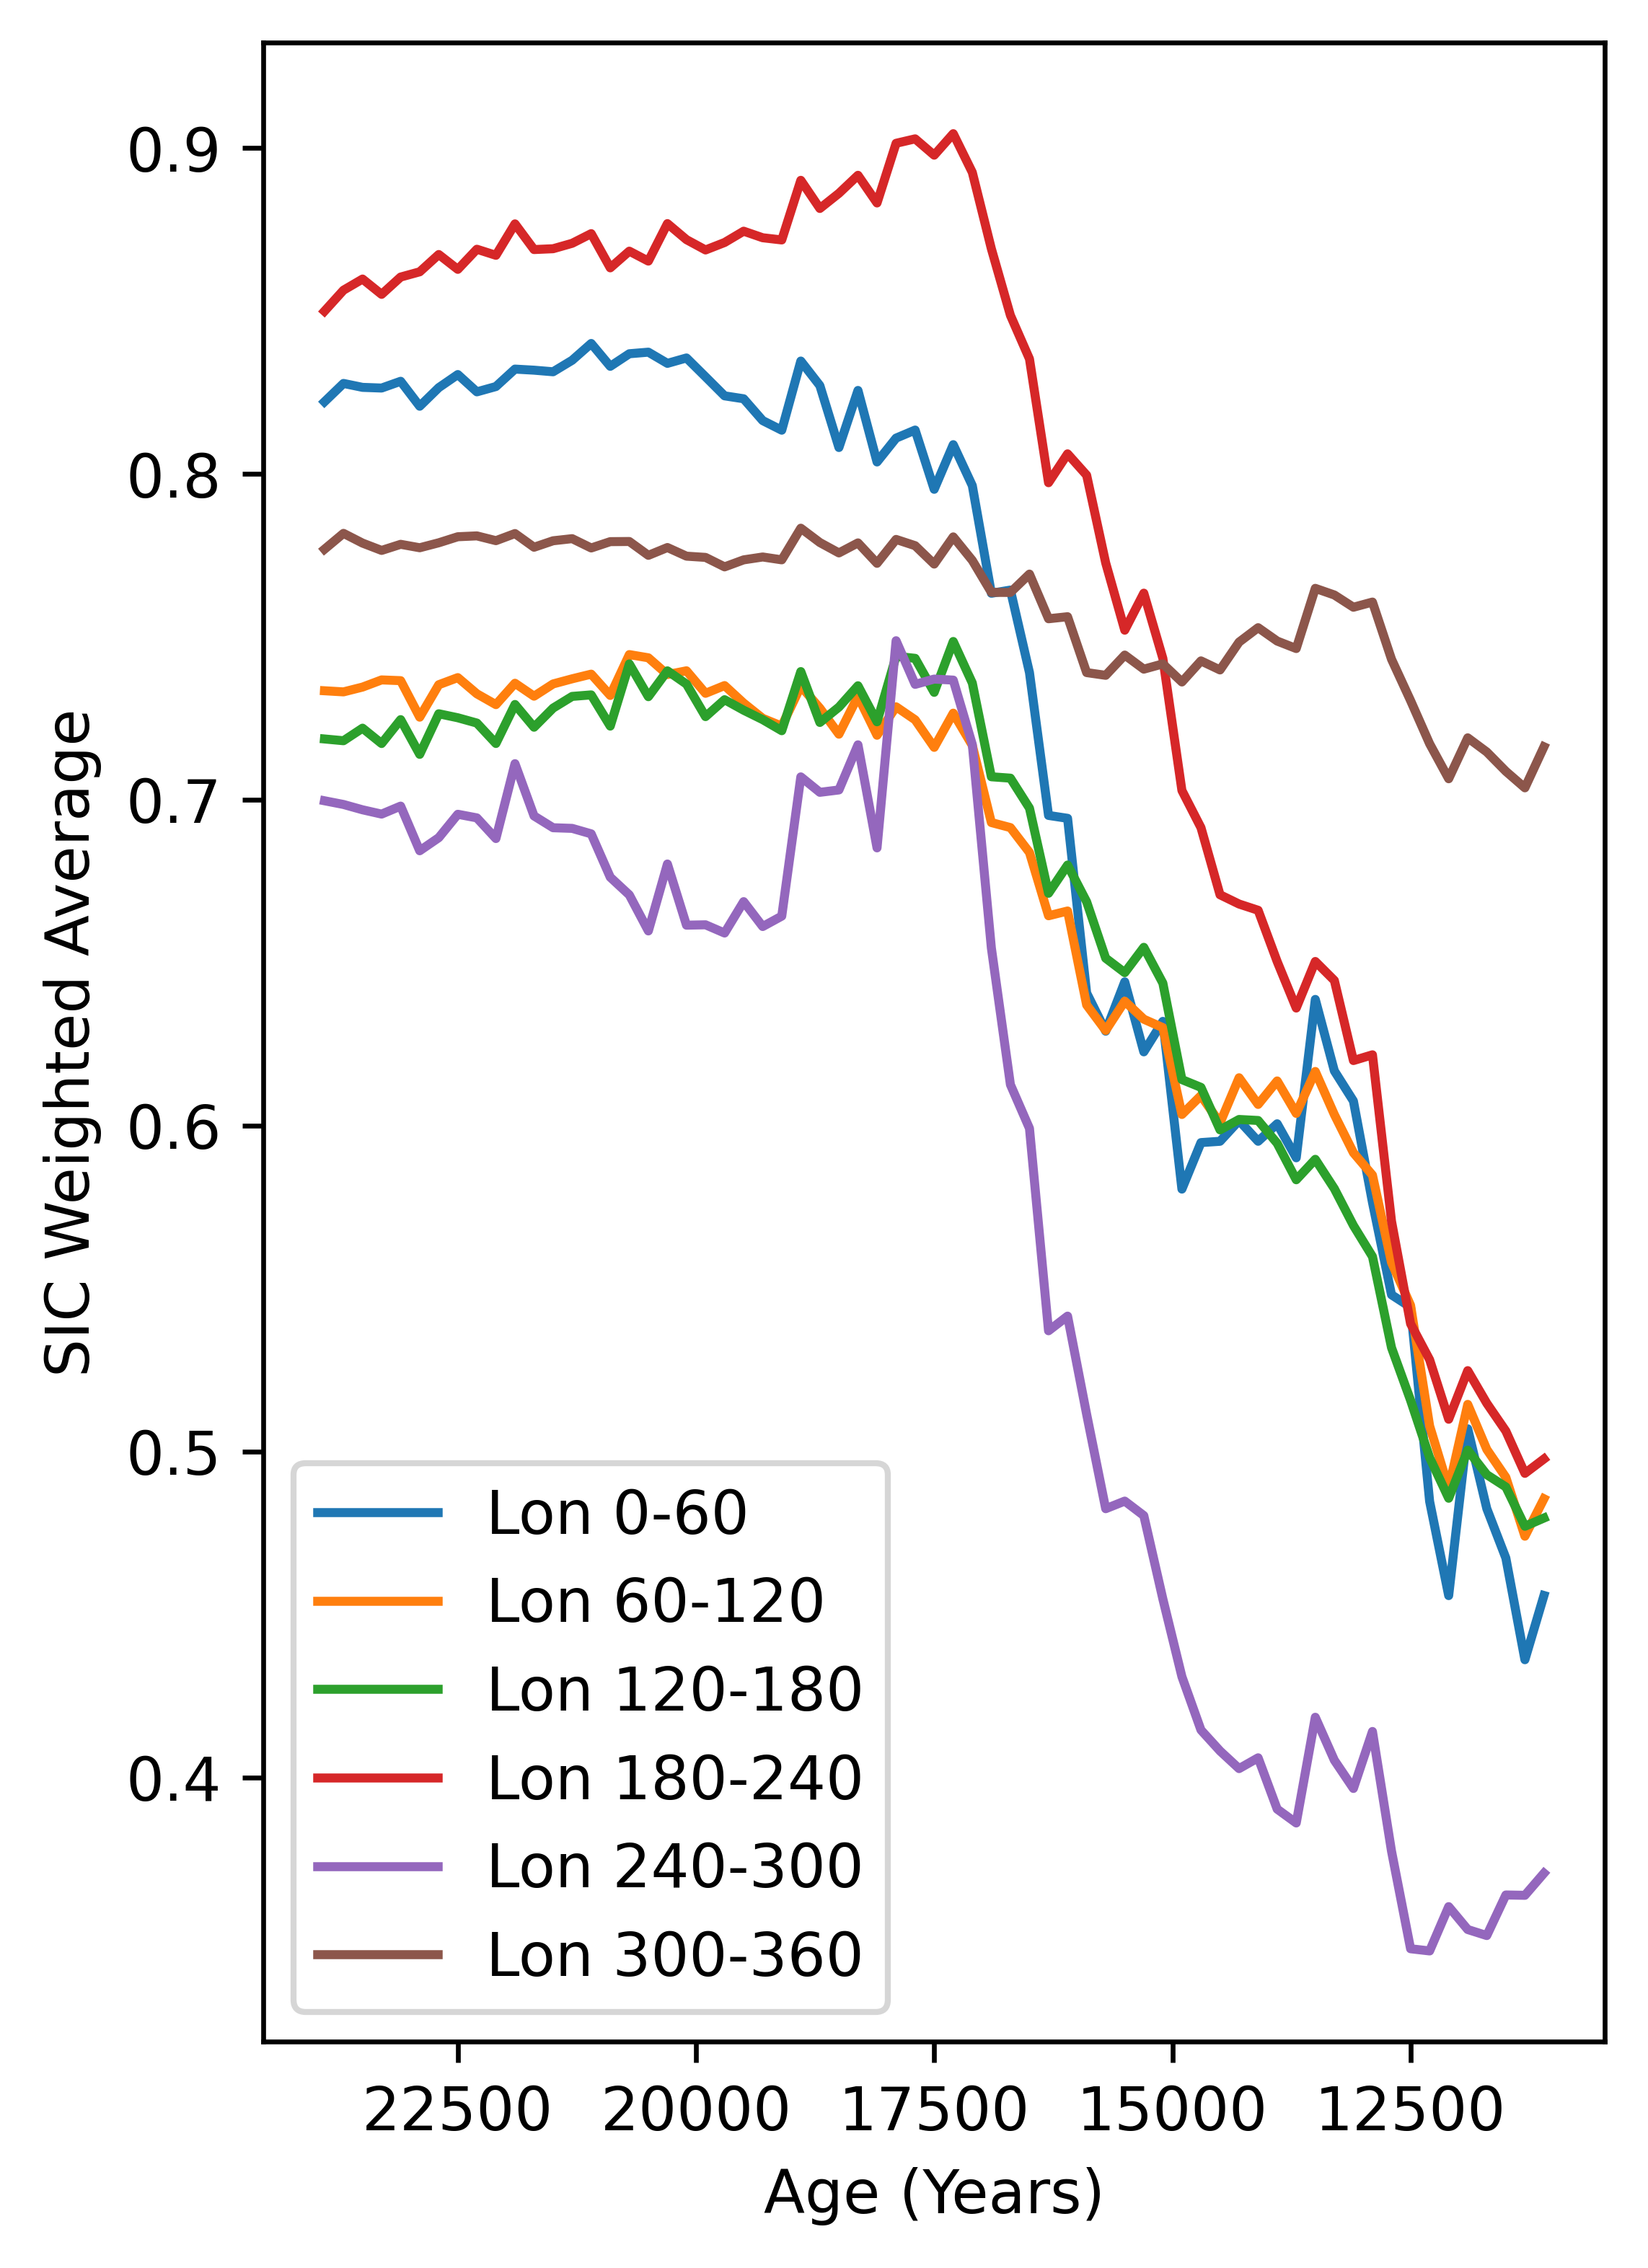

In [4]:
import matplotlib.pyplot as plt
from scipy.stats import zscore

fig, ax = plt.subplots(figsize=(4, 6),dpi=600)

if_zscore = False

# Loop through the weighted_avg_sic dictionary and plot each time series
for lon_range, data in weighted_avg_sic.items():
    if if_zscore:
        ax.plot(ds_seaice['age'].values, zscore(data), label=f'Lon {lon_range}')
    else:
        ax.plot(ds_seaice['age'].values, data, label=f'Lon {lon_range}')

# flip the x-axis
ax.invert_xaxis()
# Adding labels and title
ax.set_xlabel('Age (Years)')
ax.set_ylabel('SIC Weighted Average')
# ax.set_title('Sea Ice Concentration (SIC) Weighted Average Time Series')
ax.legend()

# Show the plot
plt.show()
